In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from dotenv import dotenv_values
from langgraph.checkpoint.memory import MemorySaver
import json
from langgraph.types import Command, interrupt
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from pptx import Presentation
from pptx.util import Inches, Pt


memory = MemorySaver()

In [2]:
config = dotenv_values(".env")

In [3]:
class AgentState(TypedDict):
    task: str
    plan: str
    stop: str
    ppt_status: str

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, openai_api_key=config["OPEN_AI_KEY"],
                  model_kwargs={"response_format": {"type": "json_object"}})

In [5]:
PLAN_PROMPT = """You are an expert Microsoft PowerPoint writer tasked with writing a high level outline for a successful business presentation. \
Write such an outline for the user provided topic. Give an outline of the PowerPoint along with any relevant notes \
or instructions for the sections. The output should be in JSON format with key named 'title' and 'content'."""

In [6]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [7]:
def powerpoint_node(state: AgentState):
    print("IN POWERPOINT NODE")

    data = json.loads(state["plan"])
    print(data)

    prs = Presentation()
    title_slide_layout = prs.slide_layouts[5]
    slide = prs.slides.add_slide(title_slide_layout)
    
    title = slide.shapes.title
    title.text = str(data["title"])
    
    left = top = width = height = Inches(1)
    txBox = slide.shapes.add_textbox(left, top, width, height)
    tf = txBox.text_frame
    
    tf.text = str(data["content"])
    
    # p = tf.add_paragraph()
    # p.text = "This is a second paragraph"
    
    # p = tf.add_paragraph()
    # p.text = "This is a third paragraph"
    
    prs.save('test.pptx')

    return {"ppt_status": "Complete"}

In [8]:
def human_assistance(state: AgentState):
    """
    Request assistance from a human to confirm if the plan or draft meets standards before creating a PowerPoint Presentation through the powerpoint node.
    
    """
    
    human_response = interrupt("Please provide feedback")

    if human_response.strip().lower() == "stop":
        return {"stop": True}

    if human_response.strip().lower() == "continue":
        return {"stop": False}
        
    return {"feedback": human_response}

In [9]:
def should_continue(state: AgentState):
    if state["stop"] == True:
        return "stop"
    return "continue"

In [10]:
builder = StateGraph(AgentState)

In [11]:
builder.add_node("planner", plan_node)
builder.add_node("powerpoint", powerpoint_node)

In [12]:
builder.add_node("human_feedback", human_assistance)

In [13]:
builder.set_entry_point("planner")

In [14]:
builder.add_edge("planner", "human_feedback")
# builder.add_edge("human_feedback", "powerpoint")
builder.add_edge("powerpoint", END)

In [15]:
builder.add_conditional_edges(
    "human_feedback", 
    should_continue, 
    {"stop": END, "continue": "powerpoint"}
)

In [16]:
graph = builder.compile(checkpointer=memory)

In [19]:
thread = {"configurable": {"thread_id": "1"}}
events = graph.stream({
    'task': "How can our clients incorporate GenAI into their workflow?"}, thread)

for event in events:
    print(event)

{'planner': {'plan': '{\n    "title": "Incorporating GenAI into Client Workflow",\n    "content": {\n        "Introduction": {\n            "content": "Brief overview of GenAI and its benefits for clients."\n        },\n        "Understanding GenAI": {\n            "content": "Explanation of what GenAI is and how it works."\n        },\n        "Benefits of GenAI": {\n            "content": "Highlight the advantages of incorporating GenAI into workflow."\n        },\n        "Integration Process": {\n            "content": "Step-by-step guide on how clients can integrate GenAI into their existing workflow."\n        },\n        "Best Practices": {\n            "content": "Recommendations on how to maximize the effectiveness of GenAI in workflow."\n        },\n        "Case Studies": {\n            "content": "Real-life examples of companies successfully using GenAI in their workflow."\n        },\n        "Q&A": {\n            "content": "Open the floor for questions and provide answer

In [20]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="continue"), thread, stream_mode="updates"
):
    print(event)
    print("\n")

{'human_feedback': {'stop': False}}


IN POWERPOINT NODE
{'title': 'Incorporating GenAI into Client Workflow', 'content': {'Introduction': {'content': 'Brief overview of GenAI and its benefits for clients.'}, 'Understanding GenAI': {'content': 'Explanation of what GenAI is and how it works.'}, 'Benefits of GenAI': {'content': 'Highlight the advantages of incorporating GenAI into workflow.'}, 'Integration Process': {'content': 'Step-by-step guide on how clients can integrate GenAI into their existing workflow.'}, 'Best Practices': {'content': 'Recommendations on how to maximize the effectiveness of GenAI in workflow.'}, 'Case Studies': {'content': 'Real-life examples of companies successfully using GenAI in their workflow.'}, 'Q&A': {'content': 'Open the floor for questions and provide answers to common queries.'}, 'Conclusion': {'content': 'Summarize key points and encourage clients to start incorporating GenAI into their workflow.'}}}
{'powerpoint': {'ppt_status': 'Complete'}}




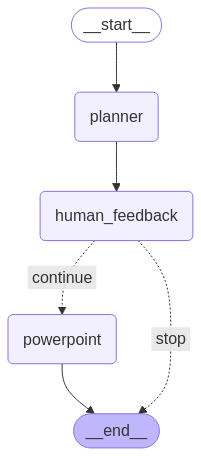

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print(Exception.with_traceback)